In [1]:
import numba
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow_probability as tfp
from numba import jit

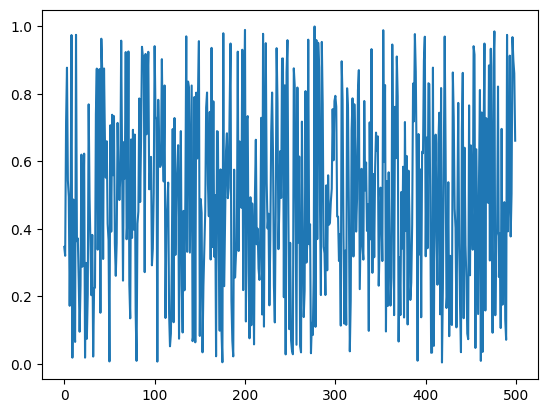

In [2]:
n = 10
p = 50
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
df = pd.DataFrame(X)

r = 5
y = np.zeros(n) #initialising y array
for i in range(n):
    yTemp = df.iloc[i,0:r].sum() + np.random.normal(0, 1) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

In [3]:
sigma1 = 1
sigma2 = 0.1
sigmay = 1
niter = 100
gamma = 0.1
rho = 1

In [4]:
p = len(X[1])
n = len(X)
b = p + n
theta = np.array([np.zeros(p)]).T #initialising theta as zero vectors
Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0]) #initialising numpy array to store A^t * z and z
for i in range(b):
    if i <= p-1:
        e = np.array([np.zeros(p)])
        e[0][i] = 1
        A = e * 1/sigma2
        if i == 0:
            Alist = A
            AtA = np.array([np.matmul(A.T, A)])
        else:
            Alist = np.vstack((Alist, A))
            AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
    else:
        X_t = X[i-p].reshape(1, p)
        A = X_t / sigmay
        Alist = np.vstack((Alist, A))
        AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))

for t in range(niter):
    print("Start of %sth iteration" % str(t))
    for i in range(b):
        if i <= p-1:
            # e = np.array([np.zeros(p)])
            # e[0][i] = 1
            # A = e * 1/sigma2
            # AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
            # AtA[i] = np.matmul(A.T, A)
            # AtA.append(np.matmul(A.T, A))
            sigsig = sigma2 / sigma1
            w1 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(1-sigsig**2) * (np.linalg.norm(np.matmul(Alist[i], theta)))**2/2)))
            w2 = 1 - w1
            U = np.random.uniform()
            if U > w1:
                mu = (1 - sigsig**2) * np.matmul(Alist[0], theta)
                sigmaz = 1 - sigsig**2
                z = np.append(z, np.random.normal(mu, sigmaz))
                # z.append(np.random.normal(mu, sigmaz))
            else:
                z = np.append(z, 0)
                # z.append(0)
            # print(A)
            Atz[i] = np.reshape(Alist[i] * z[i], (-1,1))
            
        else:
            z = np.append(z, y[i-p] / sigmay)
            Atz[i] = np.reshape(Alist[i] * z[i], (-1,1))
    # print(sum(AtA))
    print("End of sampling z values")
    sumAAtinv = np.linalg.inv(sum(AtA))
    mu_theta = np.matmul(sumAAtinv, sum(Atz))
    print(mu_theta.shape)
    sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
    L = np.linalg.cholesky(sigma_theta)
    print("Start of sampling theta")
    theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
    theta = theta_new
    # print(theta.shape)
    Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])
    print("-------------------------------------------------------")

Start of 0th iteration
End of sampling z values
(50, 1)
Start of sampling theta
-------------------------------------------------------
Start of 1th iteration
End of sampling z values
(50, 1)
Start of sampling theta
-------------------------------------------------------
Start of 2th iteration
End of sampling z values
(50, 1)
Start of sampling theta
-------------------------------------------------------
Start of 3th iteration
End of sampling z values
(50, 1)
Start of sampling theta
-------------------------------------------------------
Start of 4th iteration
End of sampling z values
(50, 1)
Start of sampling theta
-------------------------------------------------------
Start of 5th iteration
End of sampling z values
(50, 1)
Start of sampling theta
-------------------------------------------------------
Start of 6th iteration
End of sampling z values
(50, 1)
Start of sampling theta
-------------------------------------------------------
Start of 7th iteration
End of sampling z values


In [5]:
def splitGibbs(sigma1, sigma2, sigmay, X, y, niter=1000):
    gamma = 0.1
    rho = 1
    p = len(X[1])
    n = len(X)
    b = p + n
    theta = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
    for i in range(r): theta[i] = 1
    print(theta)                                   
    Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])             #initialising numpy array to store A^t * z and z
    samples = []
    for i in range(b):                                                  #generating A and A^t * A and storing them into numpy array
        if i <= p-1:
            e = np.array([np.zeros(p)])
            e[0][i] = 1
            A = e * 1/sigma2
            if i == 0:
                Alist = A
                AtA = np.array([np.matmul(A.T, A)])
            else:
                Alist = np.vstack((Alist, A))
                AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))
        else:
            X_t = X[i-p].reshape(1, p)
            A = X_t / sigmay
            Alist = np.vstack((Alist, A))
            AtA = np.vstack((AtA, np.array([np.matmul(A.T, A)])))

    for t in range(niter):                                              #Beginning of Split Gibbs Sampling
        # print("Start of %sth iteration" % str(t))
        for i in range(b):
            if i <= p-1:
                sigsig = sigma2 / sigma1
                Aitheta = np.matmul(Alist[i], theta)
                sigmaz = 1 - sigsig**2
                w2 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(sigmaz) * (np.linalg.norm(Aitheta))**2/2)))
                # print((np.linalg.norm(np.matmul(Alist[i], theta)))**2)
                w1 = 1 - w2
                U = np.random.uniform()
                if U > w2:
                    mu = (sigmaz) * Aitheta
                    z = np.append(z, np.random.normal(mu, sigmaz))
                else:
                    z = np.append(z, 0)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))
            else:
                z = np.append(z, y[i-p] / sigmay)
                Atz[i] = np.reshape(Alist[i] * z[i],(-1,1))

        # print(sum(AtA))
        # print("End of sampling z values")
        sumAAtinv = np.linalg.inv(sum(AtA))
        mu_theta = np.matmul(sumAAtinv, sum(Atz))
        # print(mu_theta.shape)
        sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
        L = np.linalg.cholesky(sigma_theta)
        # print("Start of sampling theta")
        theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
        theta = theta_new
        # print(theta.shape)
        Atz, z = np.array([np.empty((p,1))]*b), np.empty([0,0])
        samples.append(theta.T[0])
        # print("End of %sth iteration" % str(t+1))
        # print("-------------------------------------------------------")
    return samples


trace = splitGibbs(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, X = X, y = y, niter = 10000)
len(trace)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


10000

tf.Tensor(
[ 0.37132716 -0.05071724 -0.28077948  0.23755024  0.37167802  0.26188543
  0.01401162 -0.12441387 -0.13003345  0.1189418   0.14471577 -0.31937033
  0.00390967 -0.16951235  0.30152807 -0.14153732 -0.01777581  0.3702724
  0.34888813  0.13482636  0.25690833  0.16749221  0.28388318  0.06965245
 -0.01022575  0.38931552 -0.16129579  0.3228343  -0.21667041  0.3399759
  0.19013098  0.33690676  0.39658025 -0.16206005 -0.20870811  0.22672193
  0.3096717   0.16007593 -0.0550711  -0.06653579  0.3899868  -0.32369444
 -0.20021567  0.19523819 -0.18729234  0.02087905  0.22626384  0.19136018
  0.37056944  0.24255256], shape=(50,), dtype=float32)


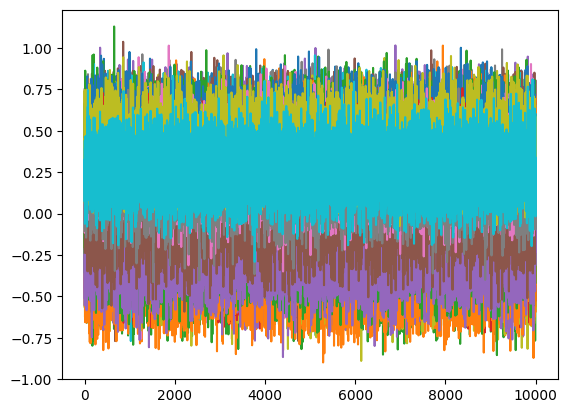

In [6]:
sample = tf.convert_to_tensor(np.asarray(trace), dtype=tf.float32)
plt.plot(sample)
ess = tfp.mcmc.effective_sample_size(sample, filter_beyond_positive_pairs=True)
# print(ess.shape)
mean, variance = tf.nn.moments(sample, axes=0)
standard_error = tf.sqrt(variance / ess)

print(mean)

In [21]:
variance

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.00195588, 0.00161997, 0.0026655 , 0.00401399, 0.00230449,
       0.0030324 , 0.00328778, 0.00337489, 0.00170583, 0.00277306],
      dtype=float32)>

In [190]:
# @jit
def splitGibbs(sigma1, sigma2, sigmay, p, n, niter=1000):
    gamma = 1
    rho = 1
    b = p + n
    theta = np.array([np.zeros(p)]).T
    AtA, Atz, z = [], [], []
    samples = []
    # samples = np.zeros(niter)
    for t in range(niter):
        # print("Start of %sth iteration" % str(t))
        for i in range(b):
            if i <= p-1:
                e = np.array([np.zeros(p)])
                e[0][i] = 1
                A = e * 1/sigma2
                AtA.append(np.matmul(A.T, A))
                sigsig = sigma2 / sigma1
                w1 = gamma * sigsig / ((gamma * sigsig) + ((1-gamma) * np.exp(-(1-sigsig**2) * (np.linalg.norm(np.matmul(A[0], theta)))**2/2)))
                w2 = 1 - w1
                U = np.random.uniform()
                if U > w1:
                    mu = (1 - sigsig**2) * np.matmul(A[0], theta)
                    sigmaz = 1 - sigsig**2
                    z.append(np.random.normal(mu, sigmaz))
                else:
                    z.append(0)
                # print(A)
                Atz.append(A.T * z[i])
                
            else:
                X_t = X[i-p].reshape(1, p)
                A = X_t / sigmay
                AtA.append(np.matmul(A.T, A))
                z.append(y[i-p] / sigmay)
                Atz.append(A.T * z[i])
                # print(z)
                # print((A.T * z[i]).shape)
        # print(sum(AtA))
        # print("End of sampling z values")
        sumAAtinv = np.linalg.inv(sum(AtA))
        mu_theta = np.matmul(sumAAtinv, sum(Atz))
        print(mu_theta)
        sigma_theta = np.linalg.inv(sum(AtA)) * rho**2
        L = np.linalg.cholesky(sigma_theta)
        # print(L)
        # print("Start of sampling theta")
        theta_new = mu_theta + np.matmul(L, np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)), (-1, 1)))
        theta = theta_new
        # print(z)
        # break
        AtA, Atz, z = [], [], []
        samples.append(theta.T[0])
        # samples[t]=theta.T[0]
        # print("-------------------------------------------------------")
    
    return samples



trace = splitGibbs(sigma1 = 1, sigma2= 0.1, sigmay= 1, p = len(X[1]), n = len(X),  niter=1000)
len(trace)

[[0.104712  ]
 [0.07551202]
 [0.05154951]
 [0.08057852]
 [0.09991069]
 [0.08317944]
 [0.04486063]
 [0.07440815]
 [0.06815568]
 [0.0801378 ]
 [0.07143425]
 [0.07998721]
 [0.06074482]
 [0.08285211]
 [0.0686669 ]
 [0.08170612]
 [0.07564344]
 [0.08269358]
 [0.06429555]
 [0.05889068]
 [0.0605254 ]
 [0.07645781]
 [0.06074278]
 [0.06922731]
 [0.05871999]
 [0.07287536]
 [0.03509185]
 [0.03923763]
 [0.06898645]
 [0.07417682]
 [0.04879879]
 [0.04379363]
 [0.0797196 ]
 [0.08400252]
 [0.05549619]
 [0.0594595 ]
 [0.07886339]
 [0.03848191]
 [0.07024021]
 [0.06285111]
 [0.05159169]
 [0.09168456]
 [0.05562521]
 [0.07117333]
 [0.07799166]
 [0.06811494]
 [0.08223763]
 [0.09888644]
 [0.07429494]
 [0.05241412]]
[[0.104712  ]
 [0.07551202]
 [0.05154951]
 [0.08057852]
 [0.09991069]
 [0.08317944]
 [0.04486063]
 [0.07440815]
 [0.06815568]
 [0.0801378 ]
 [0.07143425]
 [0.07998721]
 [0.06074482]
 [0.08285211]
 [0.0686669 ]
 [0.08170612]
 [0.07564344]
 [0.08269358]
 [0.06429555]
 [0.05889068]
 [0.0605254 ]
 [0.0

1000

In [ ]:
# trace = splitGibbs(sigma1 = 1, sigma2= 0.1, sigmay= 1, p = len(X[1]), n = len(X),  niter=10000)
# print(len(trace))

tf.convert_to_tensor(np.asarray(trace), dtype=tf.float32)

In [249]:
mean

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.08465092, 0.09671643, 0.08367188, 0.10160872, 0.10745399,
       0.10488562, 0.07075606, 0.08831891, 0.08427095, 0.10173839,
       0.09924529, 0.10168857, 0.07503489, 0.10586571, 0.08235092,
       0.09576491, 0.09366714, 0.08776692, 0.07884409, 0.0934304 ,
       0.0894822 , 0.08486786, 0.0847296 , 0.07852918, 0.07234   ,
       0.0965215 , 0.06713399, 0.06217251, 0.09570237, 0.09382877,
       0.06926697, 0.07915604, 0.09133095, 0.09452128, 0.08258278,
       0.07688358, 0.10479725, 0.06619583, 0.08686341, 0.08750252,
       0.07254537, 0.0955599 , 0.07174129, 0.10346238, 0.09868115,
       0.09002775, 0.09641039, 0.10821916, 0.0898799 , 0.07871447],
      dtype=float32)>

In [37]:
standard_error

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.00095236, 0.00092482, 0.00096537, 0.00097072, 0.00090621,
       0.00093461, 0.00090244, 0.00090522, 0.00093378, 0.00091872,
       0.00095875, 0.00093152, 0.00093021, 0.00091781, 0.00091943,
       0.00091543, 0.00091084, 0.00097259, 0.00091942, 0.00093098,
       0.00095433, 0.00095423, 0.00091596, 0.00093459, 0.00091933,
       0.00097843, 0.00093799, 0.00092285, 0.00093176, 0.00091655,
       0.00093569, 0.00092153, 0.00091046, 0.00091807, 0.0009841 ,
       0.00092142, 0.00090239, 0.00095963, 0.00093149, 0.00092909,
       0.00092483, 0.00094873, 0.00092839, 0.00095765, 0.00091716,
       0.00094028, 0.00092272, 0.00094425, 0.00093705, 0.00095854],
      dtype=float32)>

In [33]:
ess

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([82696.125, 78490.086, 85560.45 , 74864.38 , 80132.82 , 81557.35 ,
       79726.016, 85746.5  , 74356.07 , 65074.164, 85433.516, 66806.164,
       84034.78 , 74520.89 , 80009.   , 59852.15 , 38976.664, 44519.188,
       77938.445, 82318.06 , 65821.06 , 74752.69 , 76038.664, 67524.29 ,
       68344.55 , 42891.496, 17671.31 , 14775.94 , 18357.785, 56713.258,
       16410.244, 46448.86 , 69723.06 , 41663.83 , 21436.77 , 41099.098,
       24750.133, 33358.715, 57974.766, 26095.645, 31343.64 , 59399.844,
       21704.326, 25631.535, 26202.928, 18090.602, 24059.096, 43437.71 ,
       48821.254, 30004.615, 41929.91 , 21440.219, 32025.473, 42524.832,
       41760.836, 52481.035, 41680.305, 35699.13 , 28937.55 , 21232.44 ,
       41348.16 , 64633.453, 45769.55 , 28821.994, 24444.527, 48234.043,
       38585.67 , 17534.451, 60232.246, 29838.738, 42443.7  , 60628.48 ,
       40666.586, 58904.504, 20675.94 , 52796.652, 17072.01 , 48469.56 ,
   